In [ ]:
import os

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    assert os.path.exists('/content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder'), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/u/0/folders/1dqFYWetX614r49kuVE3CbZwVO6qHvRVH"
    google_colab = True
    path_to_dataset_folder = '/content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder'
    dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
    experiment_name = "WFV1_unet"
    folder_name_model_weights = os.path.join(dataset_folder,"checkpoints", experiment_name)
except ImportError as e:
    print(e)
    print("Setting google colab to false, it will need to install the gdown package!")
    google_colab = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 0b:


In [ ]:

# Download pre-trained model from Google Drive folder

if not google_colab:
    experiment_name = "WFV1_unet"
    # Download val folder
    path_to_dataset_folder = '.'
    dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
    folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)
    if not os.path.exists(folder_name_model_weights):
        import gdown
        gdown.download_folder(id="1Oup-qVD1U-re3lIQkw7TOKJsdu90blsk", quiet=False, use_cookies=False,
                              output=folder_name_model_weights)

    # Download val folder
    test_folder = os.path.join(dataset_folder, "test")
    if not os.path.exists(test_folder):
        import gdown
        os.makedirs(test_folder, exist_ok=True)
        # https://drive.google.com/drive/folders/1Bp1FXppikOpQrgth2lu5WjpYX7Lb2qOW?usp=sharing
        gdown.download_folder(id="1Bp1FXppikOpQrgth2lu5WjpYX7Lb2qOW", quiet=False, use_cookies=False,
                              output=test_folder)

## Step 1: Get config

In [ ]:
from ml4floods.models.config_setup import get_default_config

config_fp = os.path.join(folder_name_model_weights, "config.json")
# config_fp = f"gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/{experiment_name}/config.json"
config = get_default_config(config_fp)
config["model_params"]["max_tile_size"] = 1024

## Step 2: Load dataloader

In [ ]:
from ml4floods.models import dataset_setup

config.data_params.loader_type = 'local'
config.data_params.path_to_splits = dataset_folder # local folder to download the data
config.data_params.bucket_id = ""
config.data_params.train_test_split_file = None

if "filter_windows" in config["data_params"]:
    del config["data_params"]["filter_windows"]


In [ ]:
from ml4floods.data.worldfloods.dataset import WorldFloodsDatasetTiled, WorldFloodsDataset
from glob import glob
from ml4floods.models.model_setup import get_channel_configuration_bands

bands_read_s2 = get_channel_configuration_bands(config.data_params.channel_configuration)
test_files = glob(os.path.join(dataset_folder, "test","S2", "*.tif"))

train_transforms, test_transforms = dataset_setup.get_transformations(config.data_params)

test_transforms.is_check_shapes = False

test_dataset = WorldFloodsDataset(
            image_files=test_files,
            image_prefix="/S2/",
            gt_prefix="/gt/",
            bands=bands_read_s2,
            transforms=test_transforms,
            lock_read=False
        )
print(f"There are {len(test_dataset)} images in the dataset")

There are 11 images in the dataset


In [ ]:
from torch.utils.data import DataLoader
dl = DataLoader(test_dataset, batch_size=1,
                num_workers=1, shuffle=False)
# dl = data_module.val_dataloader()

## Step 3: Load a trained model

In [ ]:
from ml4floods.models.model_setup import get_model

model_folder = os.path.dirname(folder_name_model_weights)
if model_folder == "":
    model_folder = "."

config["model_params"]['model_folder'] = model_folder
config["model_params"]['test'] = True
model = get_model(config.model_params, experiment_name)

model.eval()
model.to("cuda")

Loaded model weights: /content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder/worldfloods_v1_0_sample/checkpoints/WFV1_unet/model.pt


WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

## Step 4: Run inference on all the images in the test dataset

In [ ]:
from ml4floods.models.model_setup import get_model_inference_function

if config["model_params"].get("model_version","v1") == "v2":
    inf_func = get_model_inference_function(model, config, apply_normalization=False,
                                        activation="sigmoid")
    print("v2 inference function converted to v1")
    def inference_function(x):
        dual_head_output = inf_func(x)
        B, C, H, W = dual_head_output.shape
        out = torch.zeros((B, 3, H, W),dtype=dual_head_output.dtype)
        out[:, 2] = dual_head_output[:, 0]
        out[:, 1] = (1 - dual_head_output[:, 0]) * dual_head_output[:, 1]
        out[:, 0] = (1 - dual_head_output[:, 0]) * (1 - dual_head_output[:, 1])
        return out
else:
    inference_function = get_model_inference_function(model, config, apply_normalization=False,
                                                      activation="softmax")

Getting model inference function


100%|██████████| 11/11 [04:40<00:00, 25.54s/it]


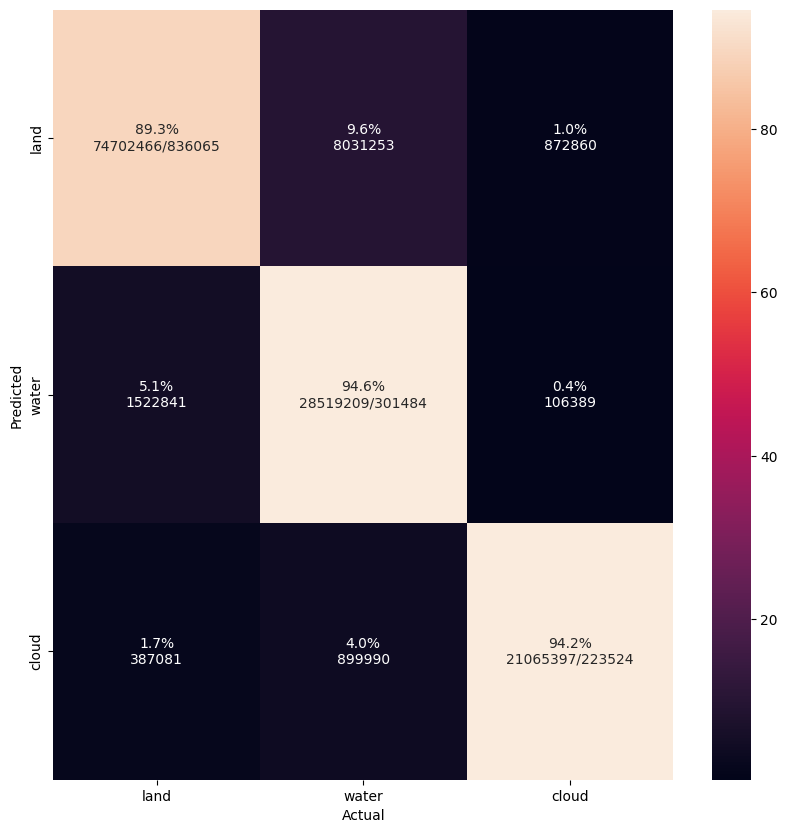

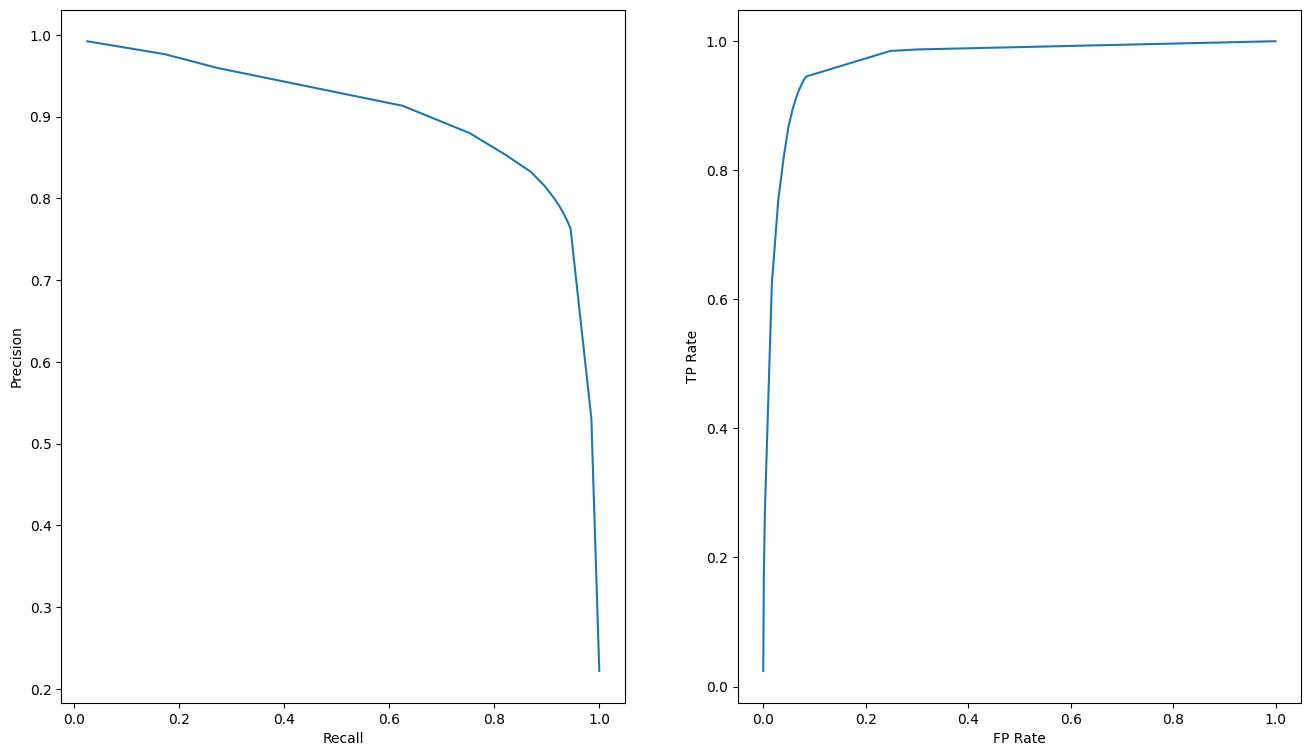

Per Class IOU {
    "cloud": 0.9028652713386631,
    "land": 0.8735444636585619,
    "water": 0.7297707540199976
}


In [ ]:
import torch
import numpy as np
import pandas as pd
from ml4floods.models.utils import metrics

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function,
    mask_clouds=False,
    convert_targets=False,
    thresholds_water=thresholds_water,
    plot=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

## Step 5: Compute the metrics for each flood in the test dataset

In [ ]:
CODES_LOC = {"EMSR333": "EMSR333 (Italy)",
             "EMSR9284": "EMSR284 (Finland)",
             "EMSR347": "EMSR347 (Malawi)",
             "EMSR286": "EMSR286 (Colombia)",
             "EMSR342": "EMSR342 (Australia)"
            }

if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code["code"] = join_data_per_code["code"].apply(lambda x: CODES_LOC.get(x,x))
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 89.14706110030056, 'Recall_water': 91.72994307314018, 'Recall_cloud': 97.21012154588949, 'IoU_land': 87.73418914523079, 'IoU_water': 74.11065148894407, 'IoU_cloud': 70.0152007262482}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR286 (Colombia),95.775230,96.068488,98.995678,94.447091,85.008647,96.262742
EMSR333 (Italy),90.770697,86.519387,99.119795,89.944669,59.832617,73.401532
EMSR342 (Australia),69.547385,97.030021,91.994864,67.459669,72.339948,89.279442
EMSR347 (Malawi),98.847444,81.699537,95.940271,96.859947,76.400101,91.132286
EMSR284 (Finland),90.794550,97.332282,100.000000,89.959569,76.971944,0.000002
